# ARCH Models on S&P 500 Stock Returns

## TIØ4317 - Project Report - Group 1

Aidan Thomas Scholes Stautland, Aina Govil Lie, Adrian Fagerland, Aleksander Fasting

# 1. Problem Statement

Accurately understanding and forecasting stock volatility is crucial for effective risk management and investment strategy optimization. While traditional measures like the VIX index focus on expected volatility, they may not accurately reflect actual volatilities for
specific stocks. This project addresses the research question:

*Which forecasting model provides the most accurate out-of-sample volatility forecasts for stocks in the S&P 500, and does the best model vary across different market conditions?*

To explore this, we focus on evaluating the performance of three volatility forecasting models under different market conditions characterized by high and low volatility. By analyzing historical data from ten companies within the S&P 500, spanning from January 1, 2010, our objective was to determine the efficacy of these models in capturing the nuances of market fluctuations. Our approach involves calculating rolling volatility using a 21-day window to reflect monthly trading days, smoothing the results with a 10-day moving average to stabilize the periods. This allows us to define periods of low and high volatility based on the stock’s own historical data. Through this comparative analysis, we aim to contribute to the understanding of how different volatility models perform under varying market conditions, thus offering insight into their applicability for financial forecasting.



# 2. Data

For this project, we used publicly available financial information sourced from Yahoo Finance, accessed via the yfinance Python module. Our dataset includes daily stock price
data for ten companies listed on the S&P 500 index. These companies were chosen from
diverse industries to ensure our model evaluation is more broadly applicable and reliable.

The selected companies are:

- Exxon Mobil Corporation (XOM) – A major multinational oil and gas corporation,
representing the energy sector.
- Meta Platforms, Inc. (META) – A prominent social media and technology firm,
capturing the dynamics of the communications and tech industry.
- Pfizer Inc. (PFE) – A global pharmaceutical leader, included to reflect the healthcare and biotech sector.
- Walmart Inc. (WMT) – As the world’s largest retailer, Walmart represents the
consumer staples and retail industry.
- Tesla, Inc. (TSLA) – Known for its electric vehicles, Tesla is a representative of
both the automotive and green energy sectors.
- Chevron Corporation (CVX) – Another key player in the energy sector, complementing Exxon Mobil.
- Citigroup Inc. (C) – A major financial services firm that captures trends within
the banking and financial sector.
- The Boeing Company (BA) – As a leading aerospace and defense manufacturer,
Boeing can provide insight into the industrial sector.
- Coterra Energy Inc. (CTRA) – An independent exploration and production company with a focus on natural gas.
- Johnson & Johnson (JNJ) – A diversified healthcare giant, adding depth to the
healthcare industry analysis.

The data spans from January 1, 2010, to the present, offering a dataset that allows
for analysis of volatility patterns across different market periods.


# 4. Empirical Analysis

## 4.1 Defining Volatility Regimes

While GARCH models forecast conditional variance, we need a measure of actual or realized volatility to evaluate these forecasts against. We calculate realized volatility based
on the historical squared de-meaned returns, $e_t^2$.

A common approach is to use a rolling window standard deviation of returns. However,
to align more closely with the variance targeted by GARCH models, we compute the
rolling variance of the de-meaned returns. We define the daily variance proxy as $e_t^2$. The
rolling realized variance over a window of N days ending at t is:

$$
\text{Realized Variance}(t) = \frac 1 N \sum_{i=0}^{N-1}e_{t-1}^2
$$

Note that this simplifies from the standard variance formula $\frac{1}{N} \sum (r_{t-i} - \bar{r})^2 = \frac{1}{N} \sum e_{t-i}^2$ because $e_{t-i}$ are already de-meaned relative to the long-term mean $\bar{r}$. We use the rolling mean of the squared errors $e_t^2$ as our measure of realized variance.

We choose a rolling window $N = 21$ days, approximating the number of trading days in a month. This measure represents the unsmoothed monthly realized variance. This will be the target variable that our GARCH forecasts aim to predict.

However, daily realized volatility can be noisy. To identify more persistent periods of high or low volatility (regimes), we apply a smoothing layer. We calculate a 10-day moving average of the 21-day rolling variance:

$$
\text{Smoothed Rolling Volatility}(t) = \frac{1}{10} \sum_{j=0}^{9} \text{Realized Variance}(t-j)
$$

This "Rolling volatility" (smoothed) will be used only to classify each day into a volatility regime (low, medium, high). It is not the target for forecasting.

To assess model performance under different market conditions, we classify each day into one of three volatility regimes: low, medium, or high. These regimes are defined based on the quantiles of the smoothed rolling volatility calculated in the previous step. This approach defines regimes relative to the stock's own historical volatility behavior, rather than using an absolute market-wide threshold.

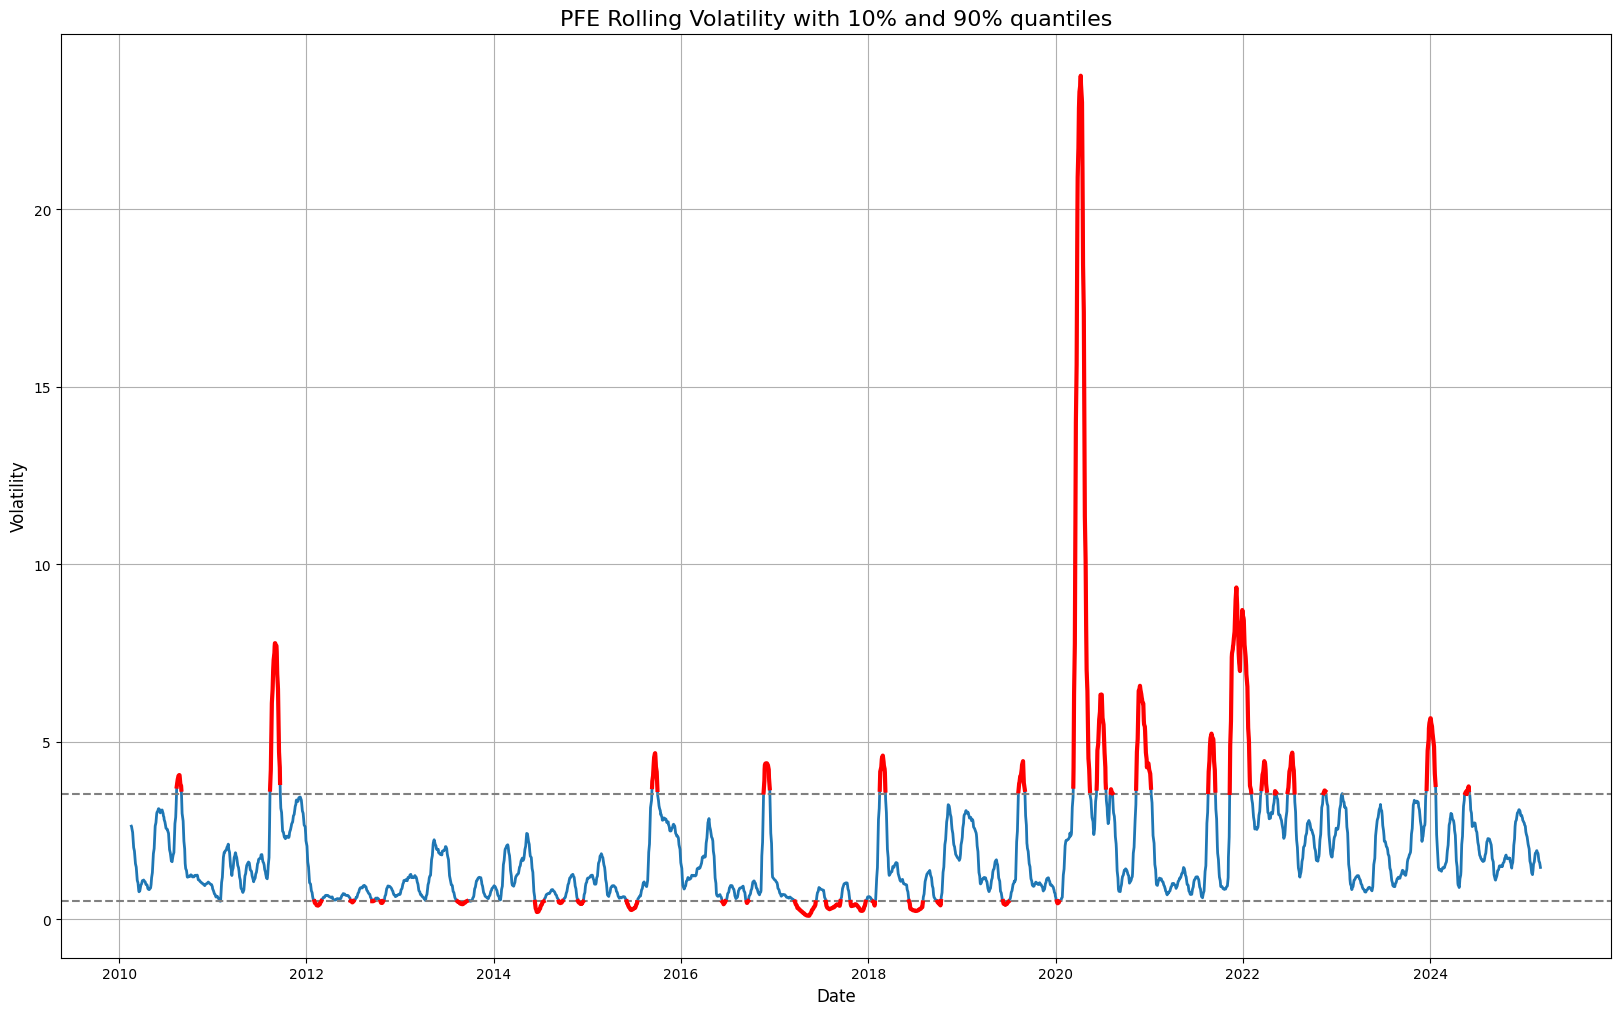

In [1]:
from tio4317_project_src import plot_quantiles_example

plot_quantiles_example()

Figure 1: PFE Rolling Volatility with 10\% and 90\% quantiles. The blue line represents the 10-day smoothed, 21-day rolling volatility. Red segments indicate periods below the 10th percentile or above the 90th percentile. (*If the code is not running, see [this](img/quantiles.png) in repo*)

## 4.2 Forecasting Methodology and Model Evaluation

We employed a rolling window forecasting approach to evaluate the out-of-sample performance of the selected models. For each day $t$ (starting after an initial burn-in period), the models were estimated using the previous 252 trading days (approximately one year) of de-meaned return data ($e$). A forecast of the average variance over the next 21 trading days (the forecast horizon, matching the rolling volatility window) was then generated. The algorithm is defined below:


-------------
### Algorithm: `General Rolling Window Forecasting`

**Inputs:**  
Time series data, Training Window Size \(W\), Forecast Horizon \(H\), Model Specification \(M\).  

**Outputs:**  
Out-of-sample Forecasts \(F\), Corresponding Actual Values \(A\).  

---------

1. Initialize forecast list $F \leftarrow \emptyset$.  
2. Initialize actuals list $A \leftarrow \emptyset$.  

3. **For** $t = T_{start}$ to $T_{end}$:  
   - Select training data window ending at \(t-1\) (size \(W\)).  
   - Fit model \(M\) to the training data.  
   - Generate forecast for the period from \(t\) to \(t+H-1\).  
   - Aggregate the \(H\)-step forecast into a single value \(f_t\).  
   - Identify the actual realized value \(a_t\) for the period \(t\) to \(t+H-1\).  
   - Append the forecast \(f_t\) to \(F\).  
   - Append the actual value \(a_t\) to \(A\).  

4. **Return** \(F, A\).
-----------------

The three models are the three discussed earlier: ARCH(1), GARCH(1,1) and GJR-GARCH(1,1). All models were fitted assuming a zero mean for the return residuals.

The performance metric used was the Root Mean Squared Error (RMSE), comparing the model's average variance forecast for the 21-day horizon ($\hat{\sigma}^2_{t, t+21}$) with the actual realized volatility proxy at the end of the forecast period ($v_{\text{unsmoothed}}(t+21)$):
$$ \text{RMSE} = \sqrt{\frac{1}{T_{\text{forecast}}} \sum_{t} (\hat{\sigma}^2_{t, t+21} - v_{\text{unsmoothed}}(t+21))^2} $$
Note that using the average variance forecast for the 21-day horizon essentially means we are trying to predict the volatility for the coming month. oRMSE was calculated separately for the entire forecast period ("Total") and for the forecasts falling into the low, medium, and high volatility regimes (determined by $v_{\text{smoothed}}(t+21)$).

## 4.3 Results across models and stocks

This code will fit and forecast the models. For in-depth code, see [here](tio4317_project_src.py).

In [2]:
from tio4317_project_src import fit_and_forecast_models

all_stock_results = fit_and_forecast_models() # This will take over 10 minutes to run

Processing XOM...
Finished processing XOM.
Processing META...
Finished processing META.
Processing PFE...
Finished processing PFE.
Processing WMT...
Finished processing WMT.
Processing TSLA...
Finished processing TSLA.
Processing CVX...
Finished processing CVX.
Processing C...
Finished processing C.
Processing BA...
Finished processing BA.
Processing CTRA...
Finished processing CTRA.
Processing JNJ...
Finished processing JNJ.

Running 30 model fits in parallel using 10 cores...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done  15 out of  30 | elapsed:  9.0min remaining:  9.0min
[Parallel(n_jobs=10)]: Done  19 out of  30 | elapsed:  9.5min remaining:  5.5min
[Parallel(n_jobs=10)]: Done  23 out of  30 | elapsed: 11.4min remaining:  3.5min
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 12.0min remaining:  1.3min



Finished all model fitting and forecasting.


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 12.6min finished


### 4.3.1 Average performance

Figure 2 presents the aggregated RMSE across all ten stocks. Several key observations emerge. Firstly, forecasting during high volatility periods consistently yields the highest RMSE for all models, indicating the inherent difficulty in accurately predicting large volatility spikes. Secondly, on average, GJR-GARCH(1,1) and GARCH(1,1) show similar performance, often outperforming the simpler ARCH(1) model, particularly in the total and medium volatility periods. In this aggregated view, GARCH(1,1) displays a slightly lower average RMSE overall and in the challenging high volatility regime compared to GJR-GARCH(1,1). Lastly, all models achieve their lowest RMSE in low volatility periods, as expected. This trend, that the RMSE is higher when the volatility is higher, is expected given how RMSE is calculating, punishing higher values.

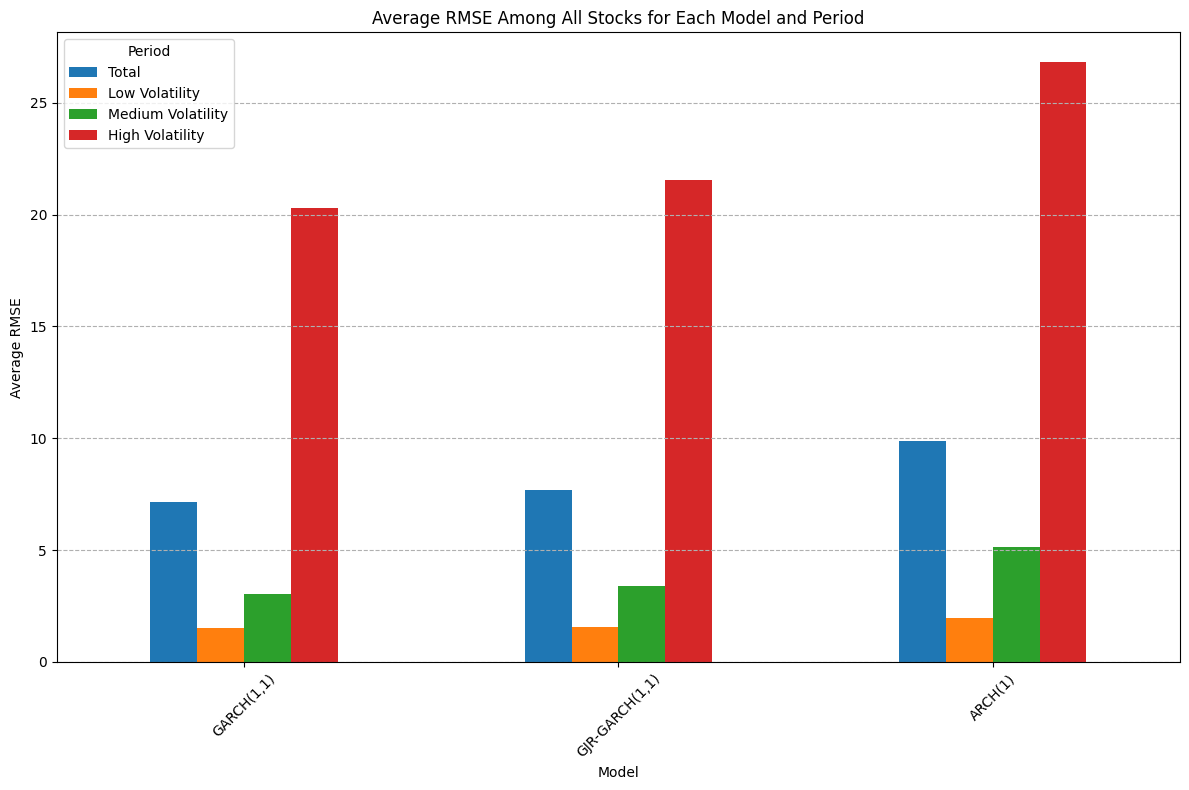


Average RMSE Table:
                   Total  Low Volatility  Medium Volatility  High Volatility
GARCH(1,1)      7.151987        1.504433           3.046794        20.310556
GJR-GARCH(1,1)  7.687125        1.562256           3.377489        21.547830
ARCH(1)         9.863318        1.946528           5.151155        26.811880


In [3]:
from tio4317_project_src import plot_average_rmse

plot_average_rmse(all_stock_results)

Figure 2: Average RMSE among All Stocks for Each Model and Period. Bars show the average RMSE for GARCH(1,1), GJR-GARCH(1,1), and ARCH(1) models, calculated over the entire forecast period and within low, medium, and high volatility regimes. (*If the code did not run, see image [here](img/rmse_overall.png)*)

### 4.3.2 Stock specific performance

While average results provide a general overview, performance can vary significantly across individual stocks. Figure 3 displays the RMSE results broken down by stock. We see that ARCH often performs on par with GARCH and GJR-GARCH, but some stocks like XOM, CVX, C, and BA have significantly worse performance in ARCH. This explains the higher average total ARCH RMSE in Figure 2.

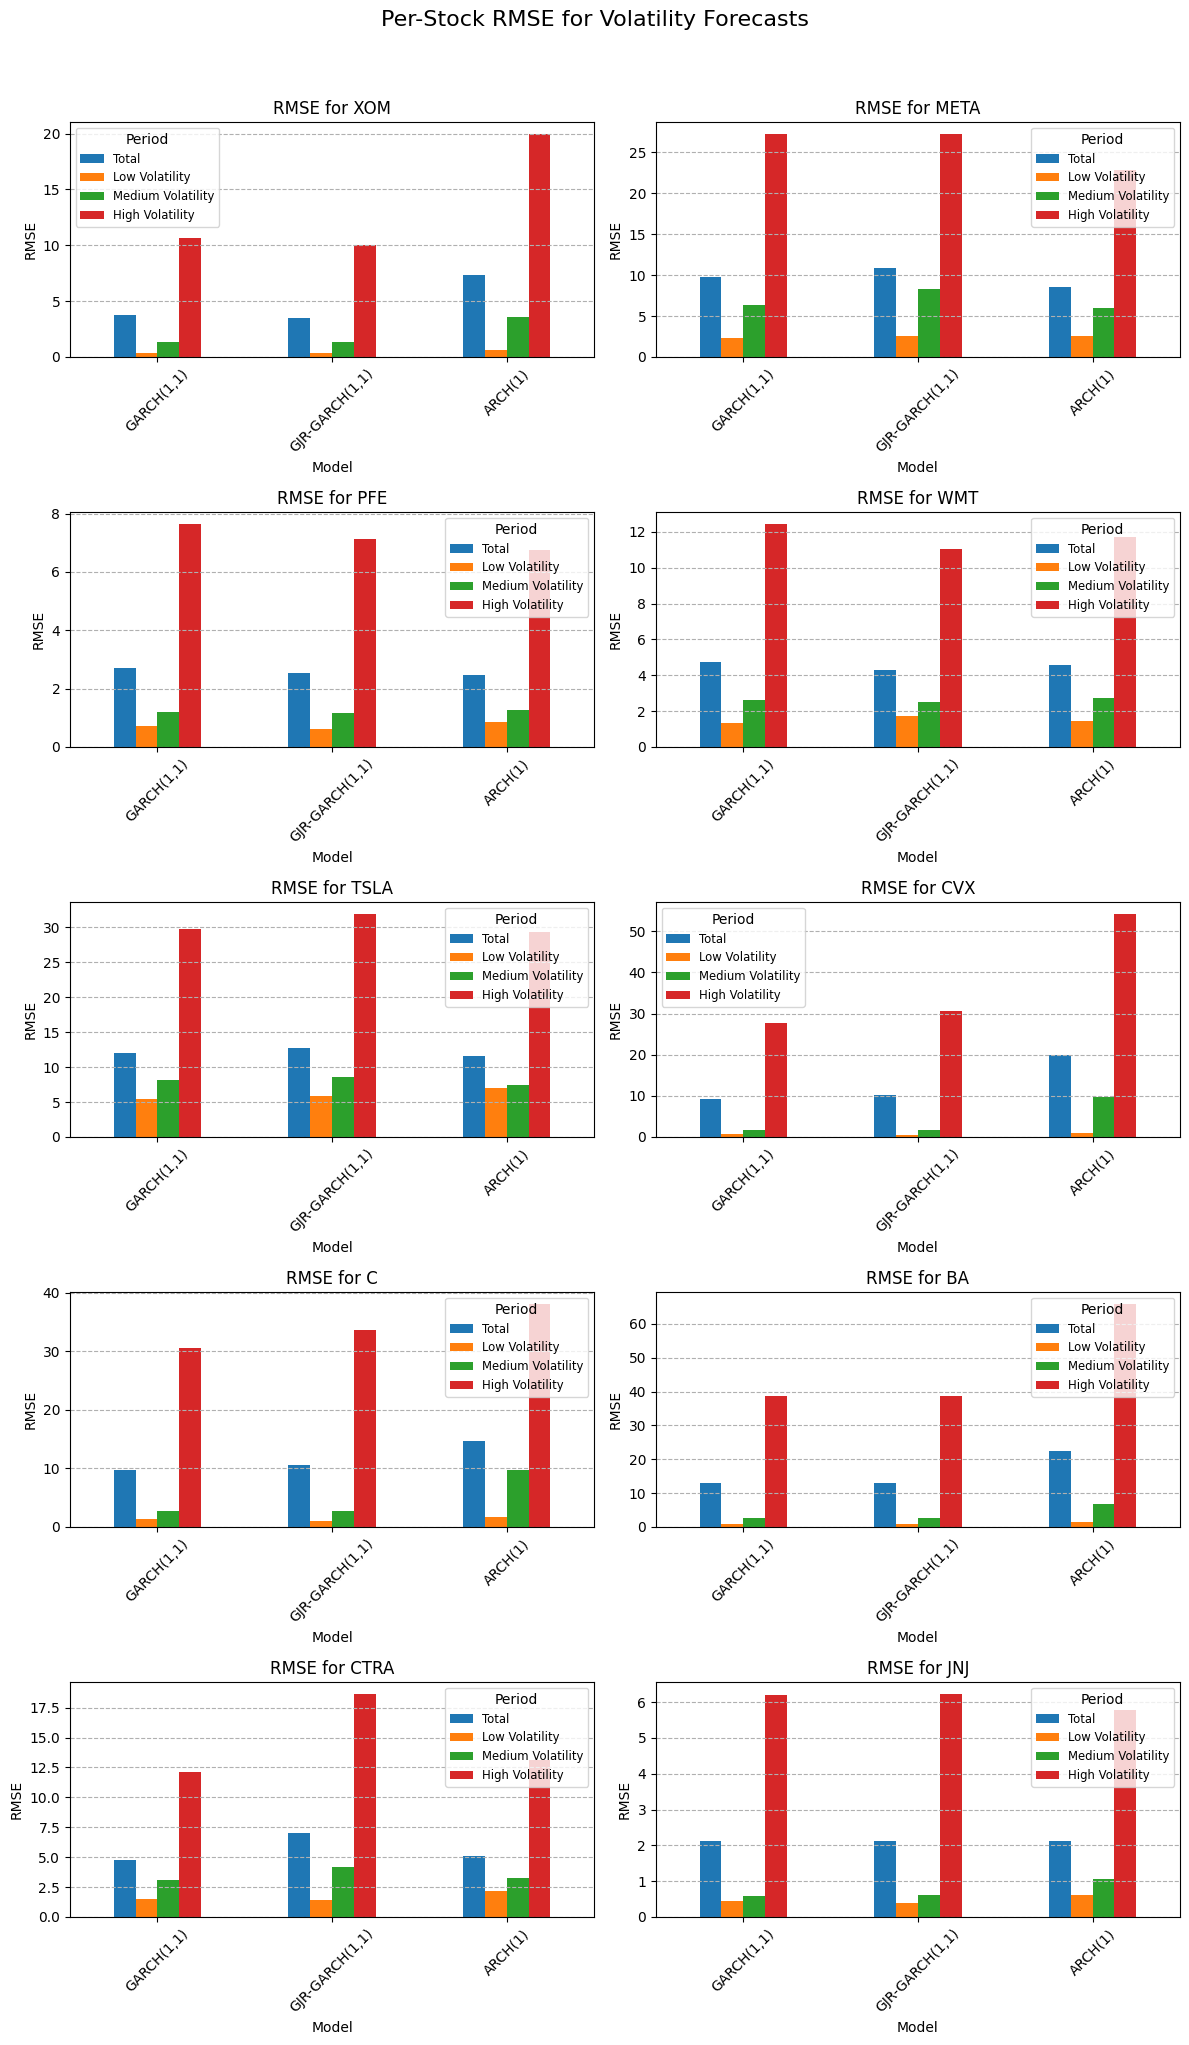

In [4]:
from tio4317_project_src import plot_rmse_across_tickers

plot_rmse_across_tickers(all_stock_results, (6,4))

Figure 3: Per-Stock RMSE for Volatility Forecasts. Bar charts show the RMSE for each model (GARCH(1,1), GJR-GARCH(1,1), ARCH(1)) and volatility regime, calculated individually for each of the ten stocks. (*If the code did not run, see figure [here](img/rmse_stock.png)*)

### 4.3.3 GARCH(p,q) parameter tuning

To investigate whether the standard GARCH(1,1) specification is optimal within the GARCH framework, we performed a parameter tuning exercise. We evaluated GARCH(p,q) models for combinations of $p \in \{1, 2, 3\}$ and $q \in \{0, 1, ..., 10\}$, excluding (0,0). The rationale for limiting $p$ was based on preliminary tests suggesting higher ARCH orders often did not improve, and could worsen, overall forecast accuracy, while higher GARCH orders ($q$) sometimes showed potential benefits.

In [ ]:
from tio4317_project_src import plot_GARCH_parametrization

plot_GARCH_parametrization()


Running 330 GARCH(p,q) evaluations in parallel using 10 cores...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  9.0min


Figure 4: Average RMSE for GARCH(p, q) Combinations Across All Stocks. Heatmaps show the average RMSE for different combinations of ARCH order (p) and GARCH order (q), separated by volatility regime (Overall, Low, Medium, High). Lighter colors indicate lower (better) RMSE. (*If code did not run, see figure [here](img/garch_parametrization.png)*)

## 4.4 Analysis

### 4.4.1 RMSE and higher volatility

Generally, we observe better RMSE performance whenever the volatility is low for some stock. We also see that the higher volatility level there is within a stock, the higher the RMSE. This makes sense, as high volatility will cause higher errors.

Across the stocks there is a 76\% correlation between volatility and total RMSE for GARCH(1,1) forecasting. There is a clear relationship between volatility and model performance irregardless of model type.

### 4.4.2 ARCH(1) performance

We see that ARCH is performing worse than GARCH(1,1) in the average forecasting in Figure \ref{fig:avg_rmse}, and some of the stocks in Figure \ref{fig:stock_rmse}. The stocks where ARCH is performing noticeably worse is XOM, CVX, C, and BA. We also take note of the industries of these companies. XOM and CVX are both Oil \& Gas giants, C is in finance, and BA is in the industrial sector.

There seems to be little correlation between volatility levels and ARCH performance, so volatility does not explain our results.

Though, we notice that the ACF curves are quite high for lags above 1 for all these companies. We see the ACFs in Figure \ref{fig:acf_abs}. There might be a negative correlation between high acf for lags above 1 and ARCH performance. We may also argue that high ACFs cause bad ARCH performance, but does not cause bad GARCH performance.

ARCH(1) is a model that is only conditional on the last shock, while GARCH(1,1) is conditional on the last variance as well. So when an ACF curve is persistent and has high magnitude, we need the model to maintain the volatility levels. GARCH solves this, but ARCH does not. We consider this to be the cause of the high RMSE values for ARC.

In turn, the cause of this might be due to industry-specific conditions. The industries where this pattern appears, like Oil \& Gas and Industrials are likely to have more persevering volatility, as they are more susceptible to sustaining market conditions like commodity prices and macroeconomic situations.

Data loaded successfully from data/XOM.csv
Data loaded successfully from data/META.csv
Data loaded successfully from data/PFE.csv
Data loaded successfully from data/WMT.csv
Data loaded successfully from data/TSLA.csv
Data loaded successfully from data/CVX.csv
Data loaded successfully from data/C.csv
Data loaded successfully from data/BA.csv
Data loaded successfully from data/CTRA.csv
Data loaded successfully from data/JNJ.csv


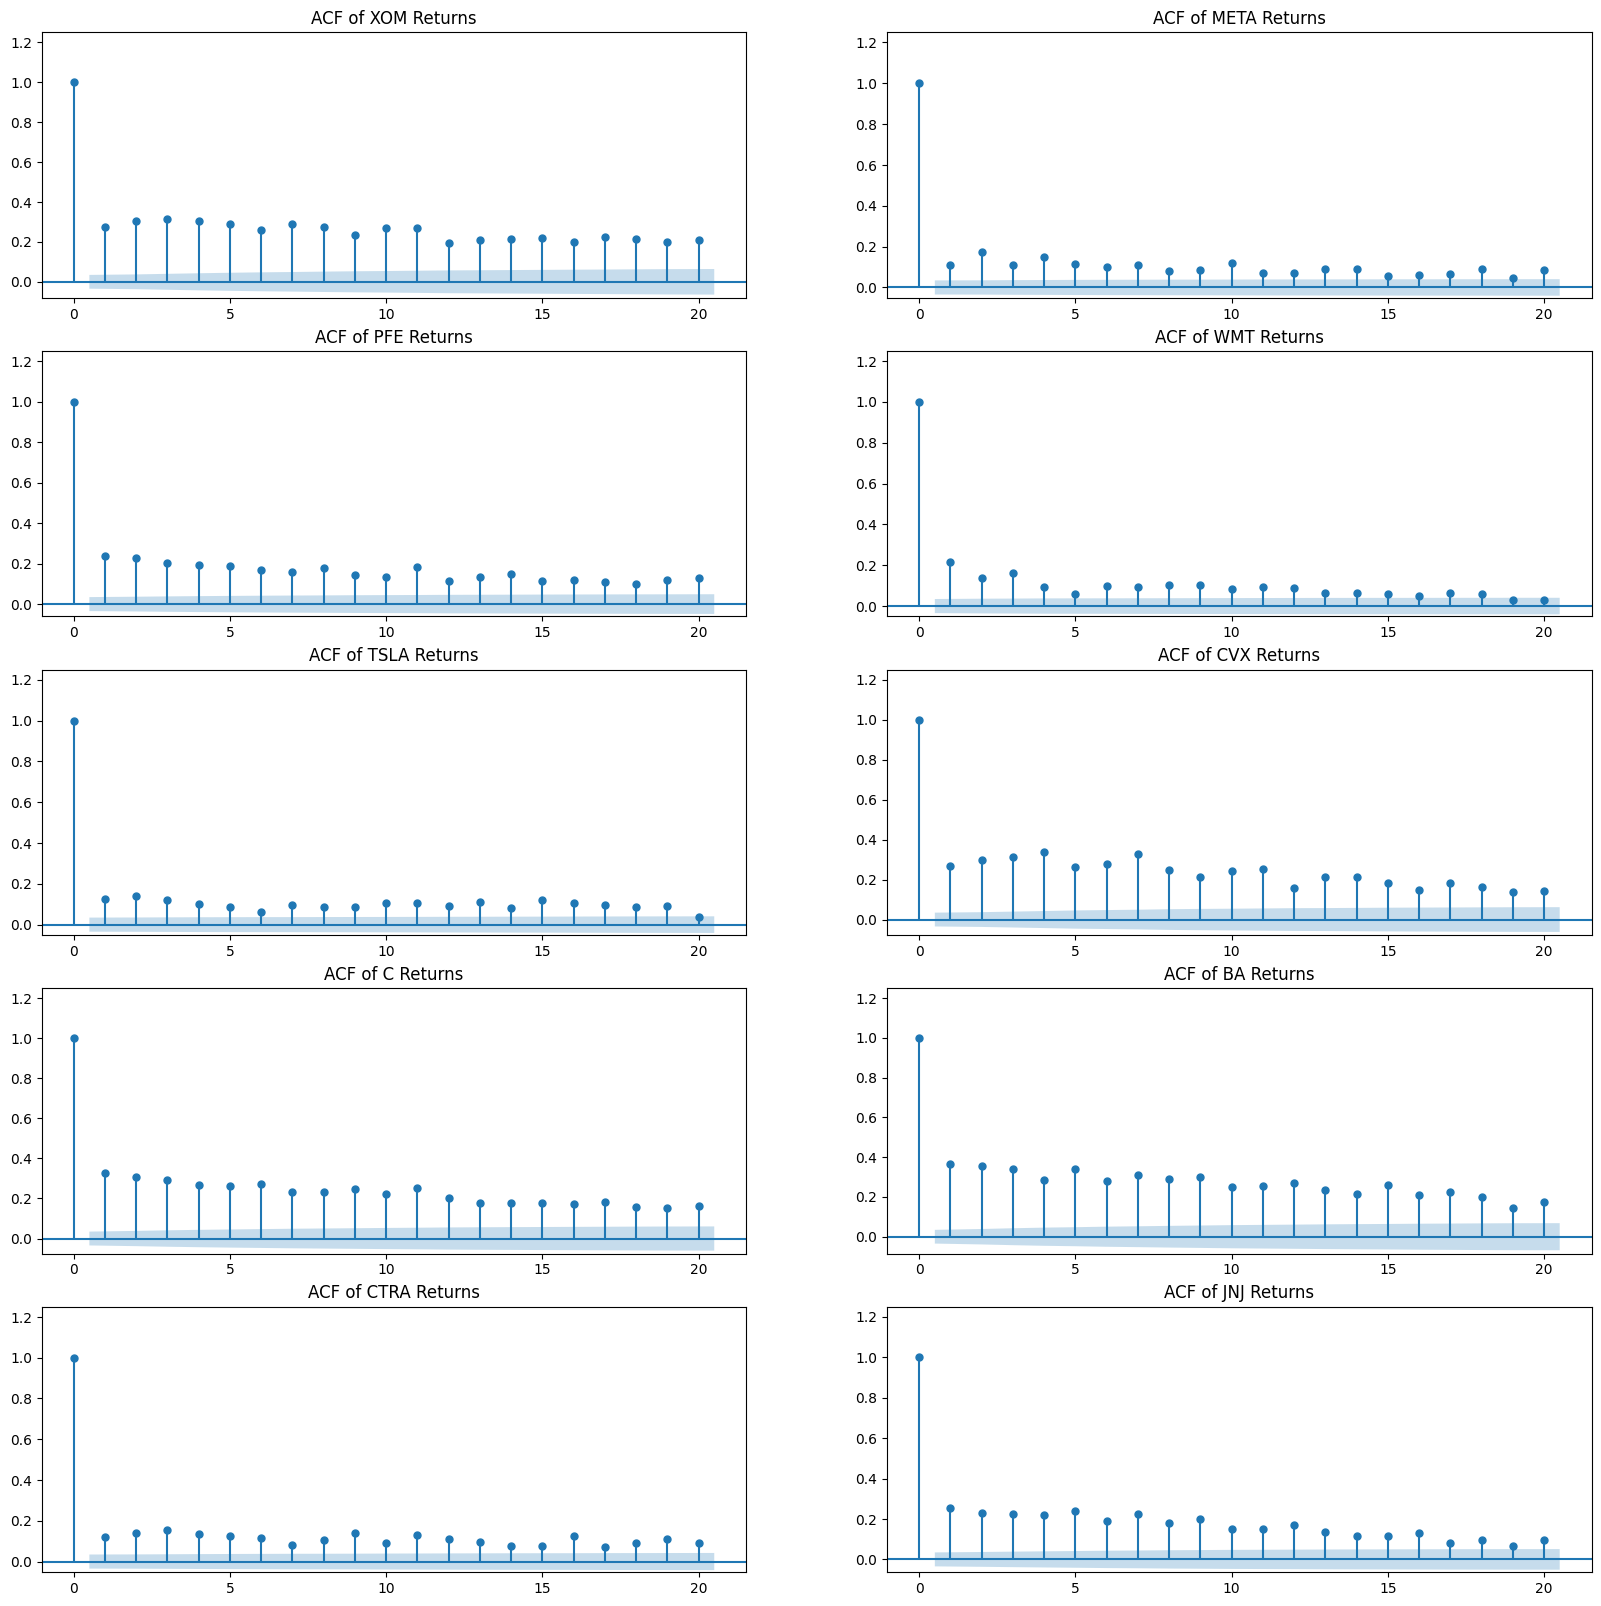

In [ ]:
from tio4317_project_src import plot_stock_acf

plot_stock_acf()

Figure 5: ACF of absolute returns on all tickers (*If code did not run, see figure [here](img/acf_abs.png)*)

### GARCH(p,q) parametrization

We discuss what trends we observe in these charts.

In Figure Figure 4 we see that there is a downward trend with ARCH order and GARCH performance. This means that shocks are only persistent with lags greater than 1.

We also observe that performance is improving with GARCH order. Though, we have not taken overfitting into consideration.

So in summary, shocks mostly persist in 1 lag, and volatility levels persist in multiple lags.

# 5. Conclusions

To summarize we see that GARCH is the best performing model. This is because it is not just shocks that are persistent within time series, but there is mostly persistent volatility levels. We also see that the best performing ARCH degree in terms of RMSE is 1, and performance drops with the order. We also see that for stocks where the acf-curves are high and somewhat constant the ARCH model is performing bad, because the GARCH takes this into consideration.

# 6. Suggestions for improvement

Having conducted our presentation for our peer group, we have been made aware of areas we could improve to better our project report. In the first instance, we could explain more clearly why we chose the three models we did, and perhaps include some benefits and drawbacks by not using other models for predicting volatility. Having run the model, we could have included another error description to increase understanding of why the RMSE was chosen to display model performance. In a future project, we would also look more closely into what the consequences of using the Absolute Log Returns of the time series were, rather than the returns or the absolute returns. It was useful for us to receive feedback from our peer group, and we will remember it for future projects.

# 6. Use of LLMs

During this project, the use of large language models (LLMs) was restricted to format conversion and minor code debugging. For format conversion, LLMs assisted in transforming LaTeX-formatted text originally written in Overleaf into Markdown format compatible with Python Jupyter notebooks. Regarding code debugging, when Python code snippets encountered runtime errors or formatting issues, LLMs were used to identify and resolve minor syntactic or logical problems. This use was strictly limited to debugging assistance and did not influence the implementation or analysis of the underlying models and results. LLMs were not used to create original content, perform data analysis, or write the report.